In [1]:
import os
import sv as SV
import numpy as np
import astropy.table as atable

import redrock
import redrock.templates
import redrock.results

from desispec.io import read_spectra
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('Agg')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
templates_path = redrock.templates.find_templates(None)
rr_templates = {}
for el in templates_path:
    t = redrock.templates.Template(filename=el)
    rr_templates[t.full_type] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [4]:
all_exps = SV.info_exposures(release='everest')

in_bright = (all_exps['FAPRGRM'] == 'bgsmws') | (all_exps['FAPRGRM'] == 'bright')
print("%i exposures in BRIGHT" % np.sum(in_bright))

sv1_exps = all_exps[(all_exps['SURVEY'] == 'sv1') & in_bright]
sv3_exps = all_exps[(all_exps['SURVEY'] == 'sv3') & in_bright]
main_exps = all_exps[(all_exps['SURVEY'] == 'main') & in_bright]

print('%i SV1 BRIGHT exposure' % len(sv1_exps))
print('%i SV3 BRIGHT exposure' % len(sv3_exps))
print('%i MAIN BRIGHT exposure' % len(main_exps))

1418 exposures in BRIGHT
635 SV1 BRIGHT exposure
298 SV3 BRIGHT exposure
409 MAIN BRIGHT exposure


In [5]:
# load compiled zsuccess rates to file
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
#dat_dir = '/global/cscratch1/sd/mjwilson/desi/BGS/bgs-cmxsv/'
#dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'


sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.v4.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.v4.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.v3.fits'))

In [6]:
sv3_gals[:5]

DEEP_NUMEXP,DEEP_TSNR2_BGS,DEEP_EXPTIME,TARGETID,Z_TRUE,DEEP_TRUE,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,ZSUCCESS,RR_ZWARN,RR_DELTACHI2,RR_SPECTYPE,RR_ZERR,RR_Z,RR_Z_DEEP,EXPID,GMAG_DRED,RMAG_DRED,FIBER_RMAG_DRED,ZMAG_DRED,W1MAG_DRED,W2MAG_DRED,FAINT_FIBCOL,EFFTIME_SPEC,SURVEY_SPEED,EFFTIME_ETC,ETC_SURVEY_SPEED,EFFTIME_TSNR2_BGS,DEEP_EFFTIME_TSNR2_BGS
int16,float32,float32,int64,float64,bool,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int64,float64,bytes6,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32
2,2393.0288,1007.7563,39627751551927574,0.07777968778663258,True,8902.65612219274,536.9451384378735 .. -8.223264137424732,0.07778355238317208,6.7423838580548705e-06,0,7873,GALAXY,,10,489.4960808902979,1,417,1417,500,0,182.55632632143863,-1.3780918631807284,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,139.2888,-379.83682,102100,0.9067837874882217,516,9010,322458,1302,SER,10.988338,16.706974,22.051287,100.7889,49.290077,12.531658,0,0,,0.0,0.0,0.0,0.0,1826m015,0.019259246,6.2602177,-2.86036,1.3781968,0.2973808,2.2115772,3.3625429,4.4381704,2.2119832,3.36349,4.4398055,6.0,4.018671,-0.10134651,-0.42885458,S,102100,9,1152921504606846976,131074,0,0,0,0,0,182.55632632143863,-1.3780918631807284,66,1,572.255,1,1,-0.001,0.001,0.001,0.001,182.55632251473406,0.0,-1.378095431121128,0.0,0.7240783,139.237,-379.755,26.098732,0.010683425,5.2018876,5.859255,67.07811,42.443214,0.27759862,0.12762439,1552.1827,3.7113695,299.07553,0.0044569364,322.69427,2190.9958,1.0549986,5.204366,3.278756e-06,11.524178,6.445858e-07,0.0,633.9811,5.033568e-06,2.5211792,5.817003,1578.2815,15.246231,304.2774,5.863712,1023.7535,2233.439,3.8537765,11.1489935,True,

In [7]:
sv1_gmag = sv1_gals['GMAG_DRED'] 
sv1_rmag = sv1_gals['RMAG_DRED'] 
sv1_zmag = sv1_gals['ZMAG_DRED']
sv1_rfib = sv1_gals['FIBER_RMAG_DRED']
sv1_colr = sv1_gals['FAINT_FIBCOL']

sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0

sv3_gmag = sv3_gals['GMAG_DRED']
sv3_rmag = sv3_gals['RMAG_DRED']
sv3_zmag = sv3_gals['ZMAG_DRED']
sv3_rfib = sv3_gals['FIBER_RMAG_DRED']
sv3_colr = sv3_gals['FAINT_FIBCOL']

sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0

In [8]:
def get_spectra(tileid, expid, petal, targetid):
    fspec = os.path.join('/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/%i/%s/' % (tileid, str(expid).zfill(8)), 
                         'spectra-%i-%i-exp%s.fits' % (petal, tileid, str(expid).zfill(8)))
    print(fspec)
    from desispec.io import read_spectra
    spec = read_spectra(fspec) 
    
    ifiber = np.arange(500)[spec.target_ids() == targetid][0]
    
    wave = np.concatenate([spec.wave['b'], spec.wave['r'], spec.wave['z']])
    flux = np.concatenate([spec.flux['b'][ifiber].flatten(), spec.flux['r'][ifiber].flatten(), spec.flux['z'][ifiber].flatten()])
    ivar = np.concatenate([spec.ivar['b'][ifiber].flatten(), spec.ivar['r'][ifiber].flatten(), spec.ivar['z'][ifiber].flatten()])
    wsort = np.argsort(wave)

    frr = os.path.join('/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/%i/%s/' % (tileid, str(expid).zfill(8)), 
                         'rrdetails-%i-%i-exp%s.h5' % (petal, tileid, str(expid).zfill(8)))
    zscan, zfit = redrock.results.read_zscan(frr) 

    zfit = zfit[zfit['targetid'] == targetid]
    zz = zfit[zfit['znum'] == 0][0] # best-fit 
    coeff = zz['coeff'] 
    fulltype = zz['spectype']
    tp = rr_templates[fulltype]
    bfs = []
    for arm in ['b', 'r', 'z']: 
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave[arm], zz['z']) * (1+zz['z'])
        res = spec.R[arm][ifiber]
        bfs.append(res.dot(mx))
    bfs = np.concatenate(bfs)
    return  wave[wsort], flux[wsort], bfs[wsort], ivar[wsort]

In [19]:
# BGS bright blue
igal0 = [116742] #np.random.choice(np.arange(len(sv3_gals))[sv3_brgt & (sv3_rmag < 18) & ((sv3_gmag - sv3_rmag) < 0.5) & ((sv3_rmag - sv3_zmag) < 0.5) & sv3_gals['ZSUCCESS']], 1)
# BGS bright red
igal1 = np.random.choice(np.arange(len(sv3_gals))[sv3_brgt & (sv3_rmag < 19) & ((sv3_gmag - sv3_rmag) > 0.5) & ((sv3_rmag - sv3_zmag) > 1.) & sv3_gals['ZSUCCESS']], 1)
print(igal0, igal1)

[116742] [10845]


In [20]:
# BGS faint blue
igal2 = [166283] #np.random.choice(np.arange(len(sv3_gals))[sv3_fain & ((sv3_gmag - sv3_rmag) < 0.5) & ((sv3_rmag - sv3_zmag) < 0.5) & sv3_gals['ZSUCCESS']], 1)
# BGS faint red
igal3 = np.random.choice(np.arange(len(sv3_gals))[sv3_fain & ((sv3_gmag - sv3_rmag) > 0.5) & ((sv3_rmag - sv3_zmag) > 1.) & sv3_gals['ZSUCCESS']], 1)
print(igal2, igal3)

[166283] [96768]


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/529/00087604/spectra-2-529-exp00087604.fits
INFO:spectra.py:282:read_spectra: iotime 0.960 sec to read spectra-2-529-exp00087604.fits at 2021-10-28T18:49:48.623686


<ipython-input-21-2d25a344eaae>:9: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/201/00083535/spectra-0-201-exp00083535.fits
INFO:spectra.py:282:read_spectra: iotime 1.085 sec to read spectra-0-201-exp00083535.fits at 2021-10-28T18:50:01.537101


<ipython-input-21-2d25a344eaae>:24: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/559/00087720/spectra-3-559-exp00087720.fits
INFO:spectra.py:282:read_spectra: iotime 0.871 sec to read spectra-3-559-exp00087720.fits at 2021-10-28T18:50:13.980270


<ipython-input-21-2d25a344eaae>:38: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/100/00087236/spectra-3-100-exp00087236.fits
INFO:spectra.py:282:read_spectra: iotime 1.116 sec to read spectra-3-100-exp00087236.fits at 2021-10-28T18:50:26.712568


<ipython-input-21-2d25a344eaae>:53: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', alpha=0.2)


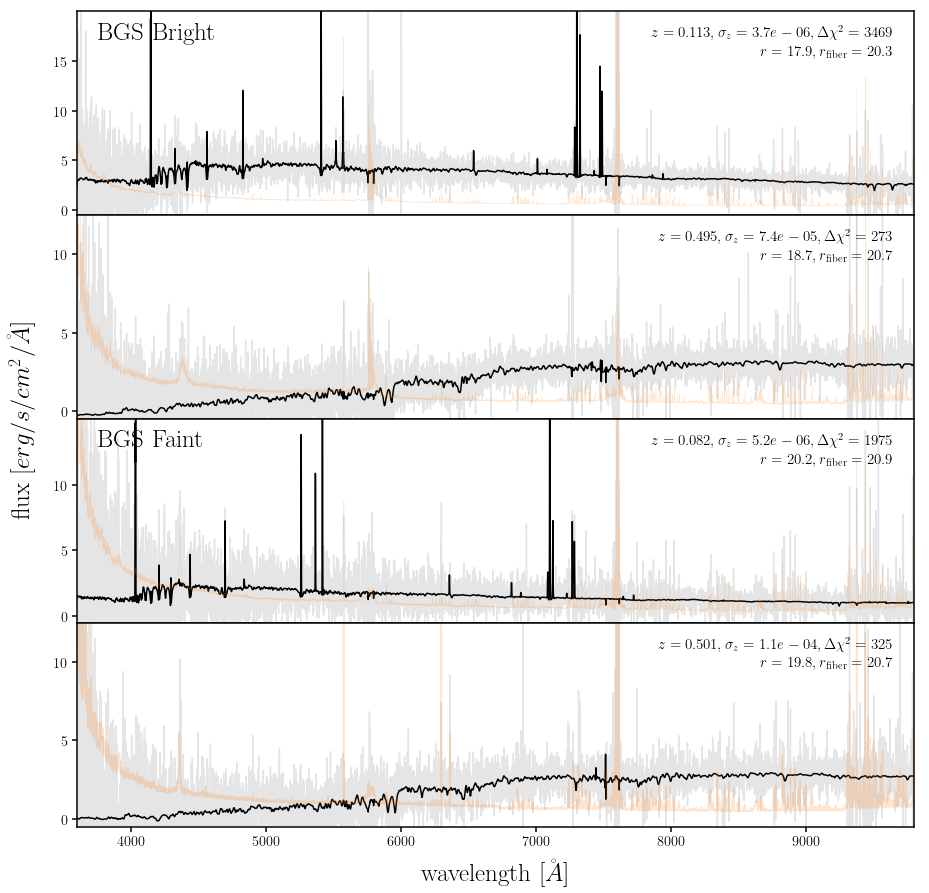

In [21]:
fig = plt.figure(figsize=(15,15))

ginfo = sv3_gals[igal0]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(411)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_bgs, f_bf, c='k')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)
sub.text(0.025, 0.95, 'BGS Bright', ha='left', va='top', transform=sub.transAxes, fontsize=25)
sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal0]['Z'], sv3_gals[igal0]['ZERR'], sv3_gals[igal0]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal0], sv3_rfib[igal0]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_xticklabels([])
sub.set_ylim(-0.5, 20)
sub.set_yticks([0., 5., 10., 15.])

ginfo = sv3_gals[igal1]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(412)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_bgs, f_bf, c='k')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)
sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal1]['Z'], sv3_gals[igal1]['ZERR'], sv3_gals[igal1]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal1], sv3_rfib[igal1]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_xticklabels([])
sub.set_ylim(-0.5, 12.5)
sub.set_yticks([0., 5., 10.])

ginfo = sv3_gals[igal2]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(413)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_bgs, f_bf, c='k')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)
sub.text(0.025, 0.95, 'BGS Faint', ha='left', va='top', transform=sub.transAxes, fontsize=25)
sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal2]['Z'], sv3_gals[igal2]['ZERR'], sv3_gals[igal2]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal2], sv3_rfib[igal2]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_xticklabels([])
sub.set_ylim(-0.5, 15)
sub.set_yticks([0., 5., 10.])

ginfo = sv3_gals[igal3]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(414)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_bgs, f_bf, c='k')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', alpha=0.2)

sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal3]['Z'], sv3_gals[igal3]['ZERR'], sv3_gals[igal3]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal3], sv3_rfib[igal3]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(-0.5, 12.5)
sub.set_yticks([0., 5., 10.])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('wavelength [$\AA$]', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'flux [$erg/s/cm^2/\AA$]', labelpad=15, fontsize=25)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig.subplots_adjust(wspace=0.1, hspace=0.0)
fig.savefig('figs/bgs_spectra.pdf', bbox_inches='tight')